In [378]:
from scipy.optimize import linprog
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from gurobi import *

from dynamic_matching import DynamicMatchingBase
np.set_printoptions(precision=3)
pd.options.display.max_columns = None
from IPython.display import display, HTML
from IPython.display import display_html

sns.set(font_scale=1.5)


### Define some utility functions for better understanding how the solvers / and online allocation is working

In [106]:
def print_alpha_allocation_view(alphas, I,T):
    display(pd.DataFrame(alphas.reshape(I,T)))
    
def debug_allocation_differences(online_allocs, offline_allocs, comps):
    diff = online_allocs - offline_allocs
    print("\nOnline allocated when it shouldn't (false positive)")
    for i in range(I):
        for j in range(J):
            for t in range(T):
                if diff[i,j,t] == 1 and i > 0:
                    print("Occurs at {},{},{}. Comparison value: {}".format(i,j,t, comps[i,j,t]))
    
    
    print("\nOnline didn't allocate when it should (false negative)")
    for i in range(I):
        for j in range(J):
            for t in range(T):
                if diff[i,j,t] == -1 and i > 0:
                    print("Occurs at {},{},{}. Comparison value: {}".format(i,j,t, comps[i,j,t]))
                    
def display_3D(tableaus_int, tableaus_float, names, c, k, T):
    '''Given an array of numpy arrays, transforms to dataframes and displays'''
    
    metadf = pd.DataFrame({
        'copies' :[c[i] for i in range(allocs.shape[0])],
        'use times' :[k[i] for i in range(allocs.shape[0])]
    })
    
    html_str = ('<th>' 
                + ''.join([f'<td style="text-align:center">{name}</td>' for name in names])
                + '</th>')

    int_ixs = len(tableaus_int)-1
    tableaus_int.extend(tableaus_float)
    
    for i in range(T):
        row_dfs = [pd.DataFrame(tableau[:,:,i]) for tableau in tableaus_int]
    
        html_str += ('<tr>' + "<td style='vertical-align:center'> t = {}".format(i) +
                     f"<td style='vertical-align:top'>{metadf.to_html(index=False, float_format='%i')}</td>" +
                     ''.join(f"<td style='vertical-align:top'> {df.to_html(index=False, float_format=ix_to_format(ix,int_ixs))}</td>"
                             for ix,df in enumerate(row_dfs)) + 
                     '</tr>')
        
    
    html_str = f'<table>{html_str}</table>'
    
    
    columns=["t="+str(t) for t in range(T)]
    index=["i="+str(i) for i in range(I)]
    dfa = pd.DataFrame(alphas.reshape(I,T),columns=columns, index=index)

    columns = ["j="+str(j) for j in range(J)]
    dfb = pd.DataFrame(betas.reshape(1,J),columns=columns)

    html_str += f'<table><th><td style="text-align:center">alpha[i,t]</td><td style="text-align:center">beta[j]</td></th><tr><td></td><td>{dfa.to_html()}</td><td>{dfb.to_html()}</td></tr></table>' 
    
    display_html(html_str, raw=True) 

    
def ix_to_format(ix,intix):
    if ix > intix:
        return '%.3e'
    elif ix > intix:
        return '%.3f'
    else:
        return '%i'
        
    
def create_allocation_vizdf(df):

    def convert_cells(cell):
        return 't='+cell.split('.')[0] if '.' in cell else ''

    df[df.columns] = df[df.columns].replace({0:np.nan}).subtract(1)
    df = df.astype(str).replace('nan', '', regex=True)
    return df.applymap(convert_cells)

def make_2D_tableau(I,J,T,pairing_weights, allocs):

    matches = np.zeros((I,J))
    match_weights = np.zeros((I,J))
    for t in range(T):
        for i in range(I):
            for j in range(J):
                if allocs[i][j][t]:
                    matches[i][j] = t+1
    match_weights = np.max(pairing_weights,axis=2)


    match_weights = np.concatenate((match_weights,betas[np.newaxis]),axis=0)
    matches = np.concatenate((matches,np.zeros((1,matches.shape[1]))),axis=0)
    
    return match_weights, matches


def display_2D(I,J,T,pairing_weights, allocs):
    
    match_weights, matches = make_2D_tableau(I,J,T,pairing_weights, allocs)

    index = ['self match'] + ['resource ' + str(i) for i in range(1, matches.shape[0]-1)] + ['betas']
    columns = ['agent '+ str(j) for j in range(matches.shape[1])]

    tabs = [matches, match_weights]
    row_dfs = [pd.DataFrame(tableau, index=index, columns=columns) for tableau in tabs]

    row_dfs[0] = create_allocation_vizdf(row_dfs[0])

    metadf = pd.DataFrame({
        'copies' :[c[i] for i in range(allocs.shape[0])] + [''],
        'use times' :[k[i] for i in range(allocs.shape[0])] + ['']
    },columns=columns, index=index)
    
    html_str = ('<th>' 
            + ''.join([f'<td style="text-align:center">{name}</td>' for name in ['resource info', 'allocations', 'match quality']])
            + '</th>')

    html_str += ('<tr>' + 
                 f"<td style='vertical-align:top'>{metadf.to_html(index=True, float_format='%i')}</td>" +
                 ''.join(f"<td style='vertical-align:top'> {df.to_html(index=True, float_format='%.3f') if ix > 0 else df.to_html(index=False,float_format='%i',columns=columns)}</td>"
                         for ix,df in enumerate(row_dfs)) + 
                 '</tr>')
    
    html_str = f'<table>{html_str}</table>'
    
    
    columns=["t="+str(t) for t in range(T)]
    index=["i="+str(i) for i in range(I)]
    dfa = pd.DataFrame(alphas.reshape(I,T),columns=columns, index=index)

    columns = ["j="+str(j) for j in range(J)]
    dfb = pd.DataFrame(betas.reshape(1,J),columns=columns)

    html_str += f'<table><th><td style="text-align:center">alpha[i,t]</td><td style="text-align:center">beta[j]</td></th><tr><td></td><td>{dfa.to_html()}</td><td>{dfb.to_html()}</td></tr></table>' 
    
    display_html(html_str, raw=True)   

### Define solver utility functions

In [445]:
def in_constraint(v):
    if v[1]:
        return True
    else:
        return False

def print_tableau(matches):
    for i in range(matches.shape[2]):
        print("t=",i)
        print(matches[:,:,i])
        
def validate_allocation(allocations):
    agents_matched = allocations.sum(axis=2).sum(axis=0).sum()
    print("{} out of {} agents matched".format(agents_matched, J))
    print("{} agents have self matched".format(allocations[0,:,:].sum()))
    print("Self-matched agents are: ", np.nonzero(allocations[0,:,:].sum(axis=1))[0])

    assert agents_matched <= J, "An agent has been matched more than once"

    for i in range(I):
        for j in range(J):
            for t in range(T):
                maxit = min(T, t+d)
                assert allocations[i,j,t:maxit].sum() <= c[i], "A resource has been over allocated"

def create_tableau(I,J,T):
    valid_matches = np.zeros((I,J,T), np.int)

    #valid allocations based on arival time
    for t in range(T):
        valid_matches[:,max(0,t-d):min(t+1,J),t] = 1

    #make weights uniform across time
    pairing_weights = np.random.random(valid_matches.shape) 
#     for t in range(1,pairing_weights.shape[2]):
#         pairing_weights[:,:,t] = pairing_weights[:,:,0]
    
    pairing_weights[0,:,:] =  0
    pairing_weights[valid_matches == 0] = -1
    pairing_weights[1:,:,:] = np.round(pairing_weights[1:,:,:],decimals=5)

    return valid_matches, pairing_weights

def make_alpha_mapping(I,J,T,alphas,valid_matches):
    '''Creates an index into the alpha array for each position in valid matches'''
    constraints_d, _ = dual_constraint_matrix(valid_matches,pairing_weights,I,J,T)
    constraints_d = constraints_d[:,:alphas.size]
    alpha_map = np.zeros((*valid_matches.shape,constraints_d.shape[1]),dtype=np.bool)

    cix=0
    for i in range(I):
            for j in range(J):
                for t in range(T):
                    if valid_matches[i][j][t]:
                        alpha_map[i,j,t,:] = constraints_d[cix,:]
                        cix += 1
    return alpha_map

def sum_alpha_it(alphas,i,t):
    '''Return the alpha terms summed at a given i,t'''
    alpha_it = alphas.reshape(I,T)
    startit = max(t-k[i]+1,0)
    return np.sum(alpha_it[i,startit:t+1])
    

To make the dual constraint matrix: 
- Create a constraint map to see which alphas/betas apply at a given location in the primal. Each valid location will correspond to a constraint in the dual, and the variables == 1 will be those in the `cmap[i][j][t]`

### Convert the problem formulation to inequalities of the form `Ax = b`

In [391]:
def primal_constraint_matrix(valid_matches, I,J,T):

    constraints = np.zeros((T*I+J,valid_matches.size),dtype=np.float128)
    cix = 0
    
    #constraints limiting to one resource allocation in the time interval
    for i in range(I):
        for t in range(T):
            constraint = np.zeros((I,J,T), np.int)
            valid_mask = constraint.copy()
            endix = min(t+k[i],T)
            valid_mask[i,:,t:endix] = 1 
            constraint[(valid_mask == 1)] = 1
            constraints[cix,:] = constraint.reshape((1, constraint.shape[0] * constraint.shape[1] * constraint.shape[2]))
            cix += 1

    #constraints limiting each agent to only match once            
    for j in range(J):
        constraint = np.zeros((I,J,T), np.int)
        valid_mask = constraint.copy()
        valid_mask[1:,j,:] = 1

        constraint[(valid_matches == 1) & (valid_mask ==1)] = 1
        constraints[cix+j,:] = constraint.reshape((1, constraint.shape[0] * constraint.shape[1] * constraint.shape[2]))
    
    return constraints


def dual_constraint_matrix(valid_matches,pairing_weights,I,J,T):
    '''
    Dual constraint matrix: Number IJT positions * number dual variables
             - Each row corresponds to an IJT position in the grid
             - Each column corresponds to a dual variable 
    '''
    num_positions = I*J*T
    num_primal_constraints = I*T+J
    dual_constraint_matrix = np.zeros((num_positions, num_primal_constraints))
    
    inequalities = np.zeros(num_positions)
    constraint_map = np.zeros((I,J,T,num_primal_constraints), np.int) 
    
    cix = 0

    #constraints limiting to one resource allocation in the time interval
    for i in range(I):
        for t in range(T):
            constraint = np.zeros((I,J,T), np.int)
            valid_mask = constraint.copy()

            endix = min(t+k[i],T)
            valid_mask[i,:,t:endix] = 1 
            constraint[(valid_mask == 1)] = 1
            constraint_map[:,:,:,cix] = constraint.copy()
            cix += 1

    #constraints limiting each agent to only match once            
    for j in range(J):
        constraint = np.zeros((I,J,T), np.int)
        valid_mask = constraint.copy()
        valid_mask[1:,j,:] = 1
        constraint[valid_mask ==1] = 1
        constraint_map[:,:,:,cix] = constraint.copy()
        cix += 1
    
    cix = 0
    for i in range(I):
        for j in range(J):
            for t in range(T):
                dual_constraint_matrix[cix,:] = constraint_map[i,j,t,:] 
                inequalities[cix] = pairing_weights[i,j,t]
                cix += 1
    
    return dual_constraint_matrix, inequalities


### Solving the primal and dual via the Gurobi library

In [109]:
def primal_solutions(pairing_weights, I, J, T):
   
    m = Model("dynamicmatch_primal")
    m.modelSense = GRB.MAXIMIZE
    m.setParam( 'OutputFlag', False )
    m.setParam( 'NumericFocus', 3)
    

    weights = pairing_weights.reshape(pairing_weights.shape[0] * pairing_weights.shape[1] * pairing_weights.shape[2])
    constraints = primal_constraint_matrix(valid_matches, I,J,T)


    keys = range(constraints.shape[1])
    variables = m.addVars(keys,
                    vtype=GRB.CONTINUOUS,
                     obj=weights,
                     name="primal",
                     lb=0)

    for cix, constraint in enumerate(constraints):
        equality = c[cix // T] if cix < T * I else 1
        m.addConstr(sum(variables[o]*c for o,c in filter(in_constraint, zip(variables,constraint))) <= equality)

    m.optimize()
    m.write('primal_formulation.lp')
    allocations = np.array([variables[var].X for var in variables], dtype=np.float128).reshape(pairing_weights.shape)

    return m.objVal, allocations


def dual_solutions(valid_matches, pairing_weights, I, J, T):
    md = Model("dynamicmatch_dual")
    md.modelSense = GRB.MINIMIZE
    md.setParam( 'OutputFlag', False )
    md.setParam( 'NumericFocus', 3)

    constraints_d, inequalities = dual_constraint_matrix(valid_matches,pairing_weights,I,J,T)
    variables_d = np.ones(constraints_d.shape[1])
    
    for ix in range(constraints_d.shape[1]):
        variables_d[ix] = c[ix // T] if ix < T * I else 1
    
    keys = range(constraints_d.shape[1])
    variables = md.addVars(keys,
                    vtype=GRB.CONTINUOUS,
                    obj=variables_d,
                    name="dual",
                    lb=0)

    for cix, constraint in enumerate(constraints_d):
        constr = inequalities[cix] + sum( variables[o]*-1*c for o,c in filter(in_constraint, zip(variables,constraint))) <= 0
        md.addConstr(constr)

    md.write('dual_formulation.lp')
        
    md.optimize()
    duals = np.array([variables[var].X for var in variables],dtype=np.longdouble)
    betas = duals[duals.size - J:]
    alphas = duals[:duals.size - J]
    
    md.write('dual_formulation.lp')
    return md.objVal, alphas, betas


In [443]:
def online_matching(I,J,T,k,c,alphas,betas,allocs,valid_matches,pairing_weights):
    '''later remove beta from comparison and simplify candidate match structure'''

    online_allocations = np.zeros(pairing_weights.shape)
    utility = 0
    candidate_matches = valid_matches.copy()
    
    resource_uses = np.zeros((pairing_weights.shape[0],pairing_weights.shape[2]))

    for t in range(T):
        for j in range(J):
    
            if candidate_matches[0,j,t]:

                alpha_sums = np.array([sum_alpha_it(alphas,i,t) for i in range(I)])
                betai = betas[j] * np.ones(alpha_sums.shape)       
                comps = pairing_weights[:,j,t] - alpha_sums - betai

                alloc_ix = get_allocation_from_comparison(comps, pairing_weights[:,j,t], c, resource_uses[:,t] )
                
                #if resource already in use wait for it to become free
                if alloc_ix != -1:
                    
                    online_allocations[alloc_ix, j, t] = 1
                    utility += pairing_weights[alloc_ix,j,t]
                    
                    #Agent only leaves the market if it doesn't self match
                    if alloc_ix != 0:
                        candidate_matches[:,j,:] = 0
                    
                    resource_uses[alloc_ix,t:t+k[alloc_ix]] += 1

    return utility, online_allocations


def get_allocation_from_comparison(comps, weights, c,resource_uses ):
    '''Returns max comparison index, max weight if tie'''
    w = weights.copy()
    
    maxval = np.max(comps)
    
    #tie case
    if sum(comps == maxval) > 1:
        tie_ixs = np.zeros(comps.shape, np.bool)
        tie_ixs[comps == maxval] = 1
        w[~tie_ixs] = -100000
        alloc_ix = np.argmax(w)
    else: 
        alloc_ix = np.argmax(comps)
    
    if resource_uses[alloc_ix] >= c[alloc_ix]:
        return -1
    
    return alloc_ix

In [442]:
pairing_weights = -1 * np.ones((2,2,4))

pairing_weights[:,:,0] = np.array([[0, -1], [4, -1]])
pairing_weights[:,:,1] = np.array([[0, 0],[4, 5]])
pairing_weights[:,:,2] = np.array([[0,0],[4, 5]])
pairing_weights[:,:,3] = np.array([[-1, 0],[-1, 5]])

valid_matches = np.zeros(pairing_weights.shape, np.int)
valid_matches[pairing_weights != -1] = 1

d=2
J=2
I=2
T = J+d 

k=np.array([1,3]) # use times
c=np.array([J,1]) # number of copies

objp, allocs = primal_solutions(pairing_weights, I, J, T)
objd, alphas, betas = dual_solutions(valid_matches,pairing_weights, I, J, T)
objo, online_allocations = online_matching(I,J,T,k,c,alphas,betas,allocs,valid_matches,pairing_weights)
objg, greedy_allocs = greedy_matching(I,J,T,k,c,valid_matches,pairing_weights)
comps = check_comp_terms(I,J,T,alphas, betas)
comp_slackness = check_comp_slackness(I,J,T,alphas,valid_matches,allocs)

print("Primal utility:",objp)
print("Dual utility:",objd)
print("Online utility:",objo)
print("Greedy utility:",objg)

names=['','Primal allocations', 'Online allocations','Greedy allocations', 'W[i,j,t] - alphas[i,t] - betas[j]', 'Pairing weights']
display_3D([allocs,online_allocations, greedy_allocs], [comps, pairing_weights], names, c, k, T)




Primal utility: 9.0
Dual utility: 9.0
Online utility: 9.0
Greedy utility: 9.0


copies,use times
2,1
1,3
0,1
0,0
1,0
0,1
0,0
1,0
0,1
0,0


In [111]:
def check_comp_terms(I,J,T,alphas, betas):
    
    comp_terms = np.zeros((I,J,T))
    for t in range(T):
        for j in range(J):
            for i in range(I):
                    comp_terms[i,j,t] = pairing_weights[i,j,t] - sum_alpha_it(alphas,i,t) - betas[j]                  
    return comp_terms

def check_comp_slackness(I,J,T,alphas,valid_matches, allocs):
    
    comp_slackness = np.zeros(valid_matches.shape)
    
    for t in range(T):
        for j in range(J):
            for i in range(I):
                    comp_slackness[i,j,t] = (pairing_weights[i,j,t] - sum_alpha_it(alphas,i,t) - betas[j]) * allocs[i,j,t]
                    
    return comp_slackness

### Greedy algorithm implementation

Basic idea: 
- For each time T, assign available resources to agents still in the market in a greedy way (choose the match that maximizes the weights in the current step)
- Do we want to perform multiple matches at a given time step? 
- For self matching, should we wait until the agent is about to leave or match immediately if a resource isn't available? Or, when making a self match don't count the agent as unavailable

In [294]:
def greedy_matching(I,J,T,k,c,valid_matches,pairing_weights):
    
    greedy_allocations = np.zeros(pairing_weights.shape)
    utility = 0
    candidate_matches = valid_matches.copy()
    resource_uses = np.zeros((pairing_weights.shape[0],pairing_weights.shape[2]))

    for t in range(T):
        
        candidate_matches_t = np.array(candidate_matches[:,:,t])
        
        while(True):  
            matches_t, weights_t = get_possible_matches(I,J,T,c,resource_uses[:,t], candidate_matches_t, pairing_weights[:,:,t])
            
            # no more matches can be made at this time
            if matches_t.sum() == 0:
                break

            i_alloc,j_alloc = np.unravel_index(weights_t.argmax(), weights_t.shape)
            
            # Only self alloc if it is the last time before departure
            if t < j_alloc + d and i_alloc == 0:
                candidate_matches_t[:,j_alloc] = 0

            else: 
                greedy_allocations[i_alloc,j_alloc,t] = 1
                utility += pairing_weights[i_alloc,j_alloc,t]

                resource_uses[i_alloc,t:t+k[i_alloc]] += 1
                candidate_matches[:,j_alloc,:] = 0
                candidate_matches_t[:,j_alloc] = 0
            
    return utility, greedy_allocations
        
    
                
def get_possible_matches(I,J,T,c, resource_uses, candidate_matches, pairing_weights):
    '''Return possible matches given arrival model and available resources'''
    
    
    candidate_matches_t = candidate_matches.copy()
    resource_uses_t = np.repeat((resource_uses < c).reshape(I,1),J, axis=1)
    
    candidate_matches_t[~(resource_uses_t)] = 0 
    pairing_weights_t =  np.array(pairing_weights)
    pairing_weights_t[0,:] = 1e-5
    pairing_weights_t[candidate_matches_t == 0] = 0
    
    
    return candidate_matches_t, pairing_weights_t

## Online assignment examples under formulation adjustment

- Self match weights are zero
- Infeasible matches are -1 (agent hasn't arrived / already departed)
- Match weights drawn from U~(0,1) and different across time


### Two small examples with match information

In [450]:
d=2
J=4
I=3
T = J+d 


valid_matches, pairing_weights = create_tableau(I,J,T)

k = np.insert(np.random.randint(kmin,kmax,size=I-1), 0, 1)
c = np.insert(np.random.randint(1,cmax,size=I-1), 0, J)

objp, allocs = primal_solutions(pairing_weights, I, J, T)
objd, alphas, betas = dual_solutions(valid_matches,pairing_weights, I, J, T)
objo, online_allocations = online_matching(I,J,T,k,c,alphas,betas,allocs,valid_matches,pairing_weights)
objg, greedy_allocs = greedy_matching(I,J,T,k,c,valid_matches,pairing_weights)
comps = check_comp_terms(I,J,T,alphas, betas)
comp_slackness = check_comp_slackness(I,J,T,alphas,valid_matches,allocs)

print("Primal utility:",objp)
print("Dual utility:",objd)
print("Online utility:",objo)
print("Greedy utility:",objg)

names=['','Primal allocations', 'Online allocations','Greedy allocations', 'W[i,j,t] - alphas[i,t] - betas[j]', 'Pairing weights']
display_3D([allocs,online_allocations, greedy_allocs], [comps, pairing_weights], names, c, k, T)


Primal utility: 1.9289399999999999
Dual utility: 1.9289399999999999
Online utility: 1.5740699999999999
Greedy utility: 1.2302499999999998


Primal allocations Online allocations Greedy allocations W[i,j,t] - alphas[i,t] - betas[j] Pairing weights t = 0 
 
 
 copies 
 use times 
 
 
 
 
 4 
 1 
 
 
 1 
 13 
 
 
 1 
 13 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 0 
 0 
 0 
 0 
 
 
 0 
 0 
 0 
 0 
 
 
 0 
 0 
 0 
 0 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 0 
 0 
 0 
 0 
 
 
 1 
 0 
 0 
 0 
 
 
 0 
 0 
 0 
 0 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 0 
 0 
 0 
 0 
 
 
 1 
 0 
 0 
 0 
 
 
 0 
 0 
 0 
 0 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 0.000e+00 
 -1.034e+00 
 -1.000e+00 
 -1.000e+00 
 
 
 0.000e+00 
 -1.647e+00 
 -1.613e+00 
 -1.613e+00 
 
 
 0.000e+00 
 -1.099e+00 
 -1.064e+00 
 -1.064e+00 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 0.000e+00 
 -1.000e+00 
 -1.000e+00 
 -1.000e+00 
 
 
 6.131e-01 
 -1.000e+00 
 -1.000e+00 
 -1.000e+00 
 
 
 6.442e-02 
 -1.000e+00 
 -1.000e+00 
 -1.000e+00 
 
 
 t = 1 
 
 
 copies 
 use times 
 
 
 
 
 4 
 1 
 
 
 1 
 13 
 
 
 1 
 13 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 0 
 0 
 0 
 0 
 
 
 0 
 0 
 0 
 0 
 
 
 0 
 0 
 0 
 0 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 0 
 1 
 0 
 0 
 
 
 0 
 0 
 0 
 0 
 
 
 0 
 0 
 0 
 0 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 0 
 0 
 0 
 0 
 
 
 0 
 0 
 0 
 0 
 
 
 0 
 1 
 0 
 0 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 0.000e+00 
 -3.442e-02 
 -1.000e+00 
 -1.000e+00 
 
 
 -2.410e-01 
 -4.068e-01 
 -1.613e+00 
 -1.613e+00 
 
 
 2.776e-17 
 -2.284e-01 
 -1.811e+00 
 -1.811e+00 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 0.000e+00 
 0.000e+00 
 -1.000e+00 
 -1.000e+00 
 
 
 3.720e-01 
 2.407e-01 
 -1.000e+00 
 -1.000e+00 
 
 
 8.112e-01 
 6.172e-01 
 -1.000e+00 
 -1.000e+00 
 
 
 t = 2 
 
 
 copies 
 use times 
 
 
 
 
 4 
 1 
 
 
 1 
 13 
 
 
 1 
 13 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 0 
 0 
 0 
 0 
 
 
 0 
 1 
 0 
 0 
 
 
 0 
 0 
 0 
 0 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 0 
 0 
 1 
 0 
 
 
 0 
 0 
 0 
 0 
 
 
 0 
 0 
 0 
 0 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 0 
 0 
 0 
 0 
 
 
 0 
 0 
 0 
 0 
 
 
 0 
 0 
 0 
 0 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 0.000e+00 
 -3.442e-02 
 0.000e+00 
 -1.000e+00 
 
 
 0.000e+00 
 0.000e+00 
 -2.390e-01 
 -1.934e+00 
 
 
 2.776e-17 
 -1.877e-01 
 -6.390e-01 
 -1.950e+00 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 0.000e+00 
 0.000e+00 
 0.000e+00 
 -1.000e+00 
 
 
 9.335e-01 
 9.679e-01 
 6.946e-01 
 -1.000e+00 
 
 
 9.499e-01 
 7.966e-01 
 3.110e-01 
 -1.000e+00 
 
 
 t = 3 
 
 
 copies 
 use times 
 
 
 
 
 4 
 1 
 
 
 1 
 13 
 
 
 1 
 13 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 0 
 0 
 0 
 0 
 
 
 0 
 0 
 0 
 0 
 
 
 0 
 0 
 0 
 0 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 0 
 1 
 1 
 1 
 
 
 0 
 0 
 0 
 0 
 
 
 0 
 0 
 0 
 0 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 0 
 0 
 0 
 0 
 
 
 0 
 0 
 0 
 0 
 
 
 0 
 0 
 0 
 0 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 -1.000e+00 
 -3.442e-02 
 0.000e+00 
 0.000e+00 
 
 
 -1.934e+00 
 -4.204e-01 
 -9.192e-01 
 -4.232e-01 
 
 
 -1.950e+00 
 -2.952e-01 
 -4.523e-01 
 -6.623e-01 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 -1.000e+00 
 0.000e+00 
 0.000e+00 
 0.000e+00 
 
 
 -1.000e+00 
 5.476e-01 
 1.433e-02 
 5.103e-01 
 
 
 -1.000e+00 
 6.892e-01 
 4.977e-01 
 2.877e-01 
 
 
 t = 4 
 
 
 copies 
 use times 
 
 
 
 
 4 
 1 
 
 
 1 
 13 
 
 
 1 
 13 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 0 
 0 
 0 
 0 
 
 
 0 
 0 
 0 
 0 
 
 
 0 
 0 
 0 
 0 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 0 
 0 
 1 
 1 
 
 
 0 
 0 
 0 
 0 
 
 
 0 
 0 
 0 
 0 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 0 
 0 
 1 
 0 
 
 
 0 
 0 
 0 
 0 
 
 
 0 
 0 
 0 
 0 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 -1.000e+00 
 -1.034e+00 
 0.000e+00 
 0.000e+00 
 
 
 -1.934e+00 
 -1.968e+00 
 -5.502e-01 
 -8.592e-01 
 
 
 -1.950e+00 
 -1.984e+00 
 -2.939e-01 
 -1.168e-01 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 -1.000e+00 
 -1.000e+00 
 0.000e+00 
 0.000e+00 
 
 
 -1.000e+00 
 -1.000e+00 
 3.834e-01 
 7.432e-02 
 
 
 -1.000e+00 
 -1.000e+00 
 6.560e-01 
 8.331e-01 
 
 
 t = 5 
 
 
 copies 
 use times 
 
 
 
 
 4 
 1 
 
 
 1 
 13 
 
 
 1 
 13 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 0 
 0 
 0 
 0 
 
 
 0 
 0 
 0 
 0 
 
 
 0 
 0 
 0 
 1 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 0 
 0 
 0 
 0 
 

In [459]:
valid_matches, pairing_weights = create_tableau(I,J,T)

k = np.insert(np.random.randint(kmin,kmax,size=I-1), 0, 1)
c = np.insert(np.random.randint(1,cmax,size=I-1), 0, J)

objp, allocs = primal_solutions(pairing_weights, I, J, T)
objd, alphas, betas = dual_solutions(valid_matches,pairing_weights, I, J, T)
objo, online_allocations = online_matching(I,J,T,k,c,alphas,betas,allocs,valid_matches,pairing_weights)
objg, greedy_allocs = greedy_matching(I,J,T,k,c,valid_matches,pairing_weights)
comps = check_comp_terms(I,J,T,alphas, betas)
comp_slackness = check_comp_slackness(I,J,T,alphas,valid_matches,allocs)

print("Primal utility:",objp)
print("Dual utility:",objd)
print("Online utility:",objo)
print("Greedy utility:",objg)

names=['','Primal allocations', 'Online allocations','Greedy allocations', 'W[i,j,t] - alphas[i,t] - betas[j]', 'Pairing weights']
display_3D([allocs,online_allocations, greedy_allocs], [comps, pairing_weights], names, c, k, T)

Primal utility: 2.81965
Dual utility: 2.81965
Online utility: 2.42819
Greedy utility: 1.9035600000000001


Primal allocations Online allocations Greedy allocations W[i,j,t] - alphas[i,t] - betas[j] Pairing weights t = 0 
 
 
 copies 
 use times 
 
 
 
 
 4 
 1 
 
 
 3 
 17 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 0 
 0 
 0 
 0 
 
 
 1 
 0 
 0 
 0 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 0 
 0 
 0 
 0 
 
 
 1 
 0 
 0 
 0 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 0 
 0 
 0 
 0 
 
 
 1 
 0 
 0 
 0 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 -4.474e-01 
 -1.000e+00 
 -1.391e+00 
 -1.329e+00 
 
 
 0.000e+00 
 -1.551e+00 
 -1.942e+00 
 -1.879e+00 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 0.000e+00 
 -1.000e+00 
 -1.000e+00 
 -1.000e+00 
 
 
 9.981e-01 
 -1.000e+00 
 -1.000e+00 
 -1.000e+00 
 
 
 t = 1 
 
 
 copies 
 use times 
 
 
 
 
 4 
 1 
 
 
 3 
 17 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 0 
 0 
 0 
 0 
 
 
 0 
 0 
 0 
 0 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 0 
 1 
 0 
 0 
 
 
 0 
 0 
 0 
 0 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 0 
 0 
 0 
 0 
 
 
 0 
 1 
 0 
 0 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 -4.474e-01 
 0.000e+00 
 -1.391e+00 
 -1.329e+00 
 
 
 -1.903e-02 
 -2.330e-03 
 -1.942e+00 
 -1.879e+00 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 0.000e+00 
 0.000e+00 
 -1.000e+00 
 -1.000e+00 
 
 
 9.791e-01 
 5.484e-01 
 -1.000e+00 
 -1.000e+00 
 
 
 t = 2 
 
 
 copies 
 use times 
 
 
 
 
 4 
 1 
 
 
 3 
 17 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 0 
 0 
 0 
 0 
 
 
 0 
 0 
 0 
 0 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 0 
 0 
 1 
 0 
 
 
 0 
 1 
 0 
 0 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 0 
 0 
 0 
 0 
 
 
 0 
 0 
 1 
 0 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 -4.474e-01 
 0.000e+00 
 -3.915e-01 
 -1.329e+00 
 
 
 -7.908e-01 
 0.000e+00 
 -5.851e-01 
 -1.879e+00 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 0.000e+00 
 0.000e+00 
 0.000e+00 
 -1.000e+00 
 
 
 2.073e-01 
 5.507e-01 
 3.571e-01 
 -1.000e+00 
 
 
 t = 3 
 
 
 copies 
 use times 
 
 
 
 
 4 
 1 
 
 
 3 
 17 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 0 
 0 
 0 
 0 
 
 
 0 
 0 
 0 
 1 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 0 
 0 
 1 
 0 
 
 
 0 
 0 
 0 
 1 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 0 
 0 
 0 
 0 
 
 
 0 
 0 
 0 
 0 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 -1.447e+00 
 0.000e+00 
 -3.915e-01 
 -3.287e-01 
 
 
 -1.998e+00 
 -2.292e-01 
 -7.059e-01 
 0.000e+00 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 -1.000e+00 
 0.000e+00 
 0.000e+00 
 0.000e+00 
 
 
 -1.000e+00 
 3.215e-01 
 2.363e-01 
 8.794e-01 
 
 
 t = 4 
 
 
 copies 
 use times 
 
 
 
 
 4 
 1 
 
 
 3 
 17 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 0 
 0 
 0 
 0 
 
 
 0 
 0 
 1 
 0 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 0 
 0 
 0 
 0 
 
 
 0 
 0 
 0 
 0 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 0 
 0 
 0 
 0 
 
 
 0 
 0 
 0 
 0 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 -1.447e+00 
 -1.000e+00 
 -3.915e-01 
 -3.287e-01 
 
 
 -1.998e+00 
 -1.551e+00 
 0.000e+00 
 -8.286e-01 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 -1.000e+00 
 -1.000e+00 
 0.000e+00 
 0.000e+00 
 
 
 -1.000e+00 
 -1.000e+00 
 9.422e-01 
 5.081e-02 
 
 
 t = 5 
 
 
 copies 
 use times 
 
 
 
 
 4 
 1 
 
 
 3 
 17 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 0 
 0 
 0 
 0 
 
 
 0 
 0 
 0 
 0 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 0 
 0 
 0 
 0 
 
 
 0 
 0 
 0 
 0 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 0 
 0 
 0 
 1 
 
 
 0 
 0 
 0 
 0 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 -1.447e+00 
 -1.000e+00 
 -1.391e+00 
 -3.287e-01 
 
 
 -1.998e+00 
 -1.551e+00 
 -1.942e+00 
 -8.115e-01 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 -1.000e+00 
 -1.000e+00 
 -1.000e+00 
 0.000e+00 
 
 
 -1.000e+00 
 -1.000e+00 
 -1.000e+00 
 6.784e-02 
 
 
 alpha[i,t] beta[j] 
 
 
 
 t=0 
 t=1 
 t=2 
 t=3 
 t=4 
 t=5 
 
 
 
 
 i=0 
 0.0000 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 
 
 i=1 
 0.5507 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 
 
 
 
 
 
 j=0 
 j=1 
 j=2 
 j=3 
 
 
 
 
 0 
 0.4474 
 0.0 
 0.39146 
 0.32869

### Comparing greedy vs. online dual vs. optimal in a slightly larger simulation

In [452]:
d=4
J=50 
I=5
T = J+d 

In [455]:
for cmax in range(2,5):
    for kmin in range(6,12,2):
        for kmax in range(14,22,2):
            
            for b in range(2):
            
                valid_matches, pairing_weights = create_tableau(I,J,T)

                k = np.insert(np.random.randint(kmin,kmax,size=I-1), 0, 1)
                c = np.insert(np.random.randint(1,cmax,size=I-1), 0, J)

                objp, allocs = primal_solutions(pairing_weights, I, J, T)
                objd, alphas, betas = dual_solutions(valid_matches,pairing_weights, I, J, T)
                objo, online_allocations = online_matching(I,J,T,k,c,alphas,betas,allocs,valid_matches,pairing_weights)
                objg, greedy_allocs = greedy_matching(I,J,T,k,c,valid_matches,pairing_weights)

                smr = np.round((J - allocs.sum()) / J, 3)

                primal_objs.append(objp)
                online_objs.append(objo)
                greedy_objs.append(objg)
                smrs.append(smr)

            
    

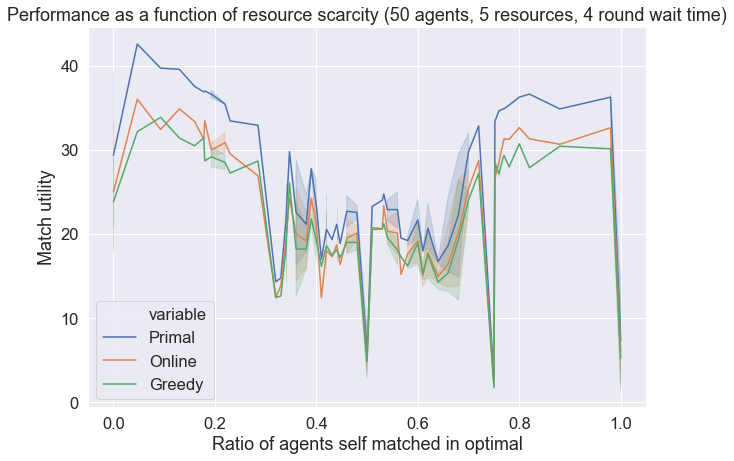

In [456]:
rundf = pd.DataFrame({'smrs': smrs, 'Primal': primal_objs, 'Online' : online_objs, 'Greedy': greedy_objs})

plt.figure(figsize=(10,7))
ax = sns.lineplot(x="smrs", y="value", data=pd.melt(rundf, ['smrs']), hue='variable')
ax.set(xlabel='Ratio of agents self matched in optimal', ylabel='Match utility', title='Performance as a function of resource scarcity (50 agents, 5 resources, 4 round wait time)')
plt.show()

# display_3D([allocs,online_allocations, greedy_allocs], [comps, comp_slackness,pairing_weights], names, c, k, T)

### Self match behavior for non-zero weights

- This demonstrates what happens in the new formulation when self-match weights are not zero

In [458]:
pairing_weights = -1 * np.ones((2,4,6))

pairing_weights[:,:,0] = np.array([[1e-5, -1, -1, -1], [.2, -1, -1, -1]])
pairing_weights[:,:,1] = np.array([[1e-5, 1e-5, -1, -1],[.2, .28, -1, -1]])
pairing_weights[:,:,2] = np.array([[1e-5,1e-5,1e-5,-1],[.2, .28, .7, -1]])
pairing_weights[:,:,3] = np.array([[-1, 1e-5,1e-5,1e-5],[-1, .28, .7, .3]])
pairing_weights[:,:,4] = np.array([[-1, -1, 1e-5,1e-5],[-1, -1, .7, .3]])
pairing_weights[:,:,5] = np.array([[-1, -1, -1, 1e-5],[-1, -1, -1, .3]])

valid_matches = np.zeros(pairing_weights.shape, np.int)
valid_matches[pairing_weights != -1] = 1

J=4
I=2
T = J+d 
d=2

k=np.array([1,3]) # use times
c=np.array([J,1]) # number of copies

objp, allocs = primal_solutions(pairing_weights, I, J, T)
objd, alphas, betas = dual_solutions(valid_matches,pairing_weights, I, J, T)
objo, online_allocations = online_matching(I,J,T,k,c,alphas,betas,allocs,valid_matches,pairing_weights)
objg, greedy_allocs = greedy_matching(I,J,T,k,c,valid_matches,pairing_weights)
comps = check_comp_terms(I,J,T,alphas, betas)
comp_slackness = check_comp_slackness(I,J,T,alphas,valid_matches,allocs)

print("Primal utility:",objp)
print("Dual utility:",objd)
print("Online utility:",objo)
print("Greedy utility:",objg)

display_3D([allocs,online_allocations, greedy_allocs], [comps, comp_slackness, pairing_weights], names, c, k, T)


Primal utility: 1.00024
Dual utility: 1.00024
Online utility: 0.98003
Greedy utility: 0.9000199999999998


Primal allocations Online allocations Greedy allocations W[i,j,t] - alphas[i,t] - betas[j] Pairing weights t = 0 
 
 
 copies 
 use times 
 
 
 
 
 4 
 1 
 
 
 1 
 3 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 4 
 0 
 0 
 0 
 
 
 0 
 0 
 0 
 0 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 1 
 0 
 0 
 0 
 
 
 0 
 0 
 0 
 0 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 0 
 0 
 0 
 0 
 
 
 1 
 0 
 0 
 0 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 0.000e+00 
 -1.000e+00 
 -1.400e+00 
 -1.000e+00 
 
 
 -8.000e-02 
 -1.280e+00 
 -1.680e+00 
 -1.280e+00 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 0.000e+00 
 -0.000e+00 
 -0.000e+00 
 -0.000e+00 
 
 
 -0.000e+00 
 -0.000e+00 
 -0.000e+00 
 -0.000e+00 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 1.000e-05 
 -1.000e+00 
 -1.000e+00 
 -1.000e+00 
 
 
 2.000e-01 
 -1.000e+00 
 -1.000e+00 
 -1.000e+00 
 
 
 t = 1 
 
 
 copies 
 use times 
 
 
 
 
 4 
 1 
 
 
 1 
 3 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 0 
 4 
 0 
 0 
 
 
 0 
 0 
 0 
 0 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 1 
 0 
 0 
 0 
 
 
 0 
 1 
 0 
 0 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 0 
 0 
 0 
 0 
 
 
 0 
 0 
 0 
 0 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 0.000e+00 
 0.000e+00 
 -1.400e+00 
 -1.000e+00 
 
 
 -8.000e-02 
 0.000e+00 
 -1.680e+00 
 -1.280e+00 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 0.000e+00 
 0.000e+00 
 -0.000e+00 
 -0.000e+00 
 
 
 -0.000e+00 
 0.000e+00 
 -0.000e+00 
 -0.000e+00 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 1.000e-05 
 1.000e-05 
 -1.000e+00 
 -1.000e+00 
 
 
 2.000e-01 
 2.800e-01 
 -1.000e+00 
 -1.000e+00 
 
 
 t = 2 
 
 
 copies 
 use times 
 
 
 
 
 4 
 1 
 
 
 1 
 3 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 0 
 0 
 4 
 0 
 
 
 0 
 0 
 1 
 0 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 1 
 0 
 0 
 0 
 
 
 0 
 0 
 0 
 0 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 0 
 0 
 0 
 0 
 
 
 0 
 0 
 0 
 0 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 0.000e+00 
 0.000e+00 
 -4.000e-01 
 -1.000e+00 
 
 
 -1.000e-01 
 -2.000e-02 
 0.000e+00 
 -1.300e+00 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 0.000e+00 
 0.000e+00 
 -1.600e+00 
 -0.000e+00 
 
 
 -0.000e+00 
 -0.000e+00 
 0.000e+00 
 -0.000e+00 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 1.000e-05 
 1.000e-05 
 1.000e-05 
 -1.000e+00 
 
 
 2.000e-01 
 2.800e-01 
 7.000e-01 
 -1.000e+00 
 
 
 t = 3 
 
 
 copies 
 use times 
 
 
 
 
 4 
 1 
 
 
 1 
 3 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 0 
 0 
 4 
 0 
 
 
 0 
 0 
 0 
 0 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 0 
 0 
 0 
 0 
 
 
 0 
 0 
 0 
 0 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 0 
 1 
 0 
 0 
 
 
 0 
 0 
 1 
 0 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 -1.000e+00 
 0.000e+00 
 -4.000e-01 
 0.000e+00 
 
 
 -1.300e+00 
 -2.000e-02 
 0.000e+00 
 0.000e+00 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 -0.000e+00 
 0.000e+00 
 -1.600e+00 
 0.000e+00 
 
 
 -0.000e+00 
 -0.000e+00 
 0.000e+00 
 0.000e+00 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 -1.000e+00 
 1.000e-05 
 1.000e-05 
 1.000e-05 
 
 
 -1.000e+00 
 2.800e-01 
 7.000e-01 
 3.000e-01 
 
 
 t = 4 
 
 
 copies 
 use times 
 
 
 
 
 4 
 1 
 
 
 1 
 3 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 0 
 0 
 4 
 0 
 
 
 0 
 0 
 0 
 0 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 0 
 0 
 0 
 0 
 
 
 0 
 0 
 1 
 0 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 0 
 0 
 0 
 0 
 
 
 0 
 0 
 0 
 0 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 -1.000e+00 
 -1.000e+00 
 -4.000e-01 
 0.000e+00 
 
 
 -1.300e+00 
 -1.300e+00 
 0.000e+00 
 0.000e+00 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 -0.000e+00 
 -0.000e+00 
 -1.600e+00 
 0.000e+00 
 
 
 -0.000e+00 
 -0.000e+00 
 0.000e+00 
 0.000e+00 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 -1.000e+00 
 -1.000e+00 
 1.000e-05 
 1.000e-05 
 
 
 -1.000e+00 
 -1.000e+00 
 7.000e-01 
 3.000e-01 
 
 
 t = 5 
 
 
 copies 
 use times 
 
 
 
 
 4 
 1 
 
 
 1 
 3 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 0 
 0 
 0 
 4 
 
 
 0 
 0 
 0 
 1 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 0 
 0 
 0 
 0 
 
 
 0 
 0 
 0 
 0 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 0 
 0 
 0 
 1 
 
 
 0 
 0 
 0 
 0 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
 
 
 
 -1.000e+00 
 -1.000e+00 
 -1.400e+00 
 0.000e+00 
 
 
 -1.300e+00 
 -1.300e+00 
 -1.700e+00 
 0.000e+00 
 
 
 
 
 
 0 
 1 
 2 
 3 
 
